In [1]:
# !pip install catboost

In [2]:
# !pip install ml_metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
merged = pd.read_csv('data/merged_data.csv', index_col=None)
merged.head()

D:\programs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,0,139128,1050,97633689,236.89,1,0.0,5045454,3573,122,119,-1,-1,-1,-1,-1,-1,-1
1,1,139128,1050,97633791,178.16,1,0.0,73719,5154,122,119,-1,-1,-1,-1,-1,-1,-1
2,2,139128,1050,97635201,173.28,1,0.0,7000939,2846,85,84,-1,-1,-1,-1,-1,-1,-1
3,3,139128,1050,97635312,73.69,1,0.0,7386015,3342,85,84,-1,-1,-1,-1,-1,-1,-1
4,4,139128,1050,97635414,282.14,1,0.0,73291,2846,85,84,-1,-1,-1,-1,-1,-1,-1


In [3]:
print(merged['user_id'].nunique())
print(merged['product_id'].nunique())
print(len(merged))

merged = merged[merged['product_id'] != 0]
print(len(merged))

107068
91994
21677070
21466723


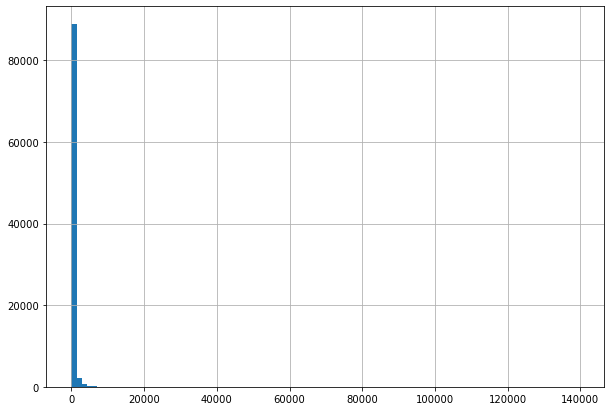

In [4]:
plt.figure(figsize=(10, 7))
merged['product_id'].value_counts().hist(bins=100)

In [5]:
merged['user_id'].nunique()

107066

In [6]:
groupby_0 = pd.DataFrame({'count' : merged.groupby(['product_id']).size()}).reset_index()
groupby_0 = groupby_0.sort_values(['count'], ascending=False)
groupby_0.head(3)

,product_id,count
193,709,139570
9290,39590,44804
71,166,36970


In [7]:
# доля покрытия
print(groupby_0[:1000]['count'].sum() / groupby_0['count'].sum())
print(groupby_0[:15000]['count'].sum() / groupby_0['count'].sum())
print(groupby_0[:35000]['count'].sum() / groupby_0['count'].sum())

0.28358841729126516
0.8288523124838384
0.9561352238066332


In [8]:
# фильтруем по продуктам
top_products = groupby_0[:15000]['product_id'].tolist()

merged = merged[merged['product_id'].isin(top_products)]
print(len(merged))
print(merged['user_id'].nunique())

17792743
106621


In [9]:
users_n_orders = merged.groupby(['user_id'])['order_id'].nunique().to_frame('count').reset_index()
users_n_orders.head(3)

,user_id,count
0,51,17
1,65,23
2,400,5


In [10]:
valid_users = users_n_orders[users_n_orders['count'] >= 2]
valid_users_ids = valid_users['user_id'].tolist()
print('valid_users_ids', len(valid_users_ids))

merged = merged[merged['user_id'].isin(valid_users_ids)]
print(len(merged))

valid_users_ids 86647
17419118


In [11]:
merged_ = merged[merged['order_created_time'].values != -1]
merged_ = merged_[merged_['order_created_time'].values != '-1']
merged_ = merged_.drop(columns=['Unnamed: 0']) 

# Change data types to reduce memory footprint
merged_ = merged_.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'order_created_time': str,
    'retailer': 'int32',
    'platform': 'int32',
    'city_name': 'int32',
    'gender': 'int32',
    'age': 'int32'}, copy=False)

merged_['order_created_time'] = pd.to_datetime(merged_['order_created_time'], format='%Y-%m-%d %H:%M:%S', exact=True)

In [12]:
last_order = merged_.groupby(['user_id'])['order_created_time'].max().to_frame('order_created_time').reset_index()
last_order.head(3)

,user_id,order_created_time
0,400,2020-07-09 12:01:19
1,576,2020-09-04 17:33:47
2,608,2020-08-29 05:52:55


In [13]:
target = pd.merge(merged_, last_order, on=['user_id', 'order_created_time']) 
print(len(target))

target_user_product_pos = target[['user_id', 'product_id']]
target_user_product_pos['target'] = 1
target_user_product_pos = target_user_product_pos.drop_duplicates()
target_user_product_pos.head(3)

1656923


<ipython-input-13-010643d31bc5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_user_product_pos['target'] = 1


,user_id,product_id,target
0,684753,55134,1
1,684753,26751,1
2,684753,14681,1


In [14]:
# коряво
last_order['user_date'] = last_order['user_id'].apply(str) + last_order['order_created_time'].apply(str)
merged_['user_date'] = merged_['user_id'].apply(str) + merged_['order_created_time'].apply(str)

merged_ = merged_[~merged_['user_date'].isin(set(last_order['user_date']))]
len(merged_)

14988011

In [15]:
del merged

In [16]:
merged_.head(3)

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age,user_date
282503,5531326,691783,28336408,40.000000,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22,6917832019-12-31 21:29:17
282504,5531326,691783,28336410,139.000000,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22,6917832019-12-31 21:29:17
282505,5531326,691783,28336411,49.900002,1,39.990002,57951,104,581,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22,6917832019-12-31 21:29:17


In [17]:
features = merged_.groupby(['user_id', 'product_id', 'master_category_id', 
                            'parent_category_id']).agg(
    product_count=pd.NamedAgg(column='product_id', aggfunc='count'),
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
    last_date_purchase=pd.NamedAgg(column='order_created_time', aggfunc='max'),
).reset_index()
            
features.head(3)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,last_date_purchase
0,400,41,85,84,1,0.0,0.0,0.0,59.000000,59.000000,59.000000,2020-06-19 11:57:25
1,400,177,26,20,1,0.0,0.0,0.0,74.889999,74.889999,74.889999,2020-06-13 13:26:03
2,400,397,38,35,1,139.0,139.0,139.0,265.000000,265.000000,265.000000,2020-06-29 19:14:42


In [18]:
train = pd.merge(features, target_user_product_pos, on=['user_id', 'product_id'], how='outer')
train['target'] = train['target'].fillna(0)
print(train['target'].value_counts())
print(train['target'].value_counts(normalize=True))
train.head(3)

0.0    9682585
1.0    1629580
Name: target, dtype: int64
0.0    0.855944
1.0    0.144056
Name: target, dtype: float64


,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,last_date_purchase,target
0,400,41,85.0,84.0,1.0,0.0,0.0,0.0,59.000000,59.000000,59.000000,2020-06-19 11:57:25,0.0
1,400,177,26.0,20.0,1.0,0.0,0.0,0.0,74.889999,74.889999,74.889999,2020-06-13 13:26:03,1.0
2,400,397,38.0,35.0,1.0,139.0,139.0,139.0,265.000000,265.000000,265.000000,2020-06-29 19:14:42,0.0


In [19]:
# add user properities

# средний размер корзины
users_info_0 = merged_.groupby(['user_id', 'order_id']).agg(
    orders_size=pd.NamedAgg(column='product_id', aggfunc='count'),
).reset_index()

users_info_1 = users_info_0.groupby(['user_id']).agg(
    avg_order_size=pd.NamedAgg(column='orders_size', aggfunc='mean'),
).reset_index()

users_info = merged_.groupby(['user_id']).agg(
    orders_count=pd.NamedAgg(column='order_id', aggfunc='count'),
    last_order_date=pd.NamedAgg(column='order_created_time', aggfunc='max'),
    first_order_date=pd.NamedAgg(column='order_created_time', aggfunc='min'),
    freq_retailer=pd.NamedAgg(column='retailer', aggfunc=lambda x:x.value_counts().index[0]), # mode
).reset_index()

users_info = pd.merge(users_info, users_info_1, on='user_id')
users_info.head(3)

,user_id,orders_count,last_order_date,first_order_date,freq_retailer,avg_order_size
0,400,107,2020-06-29 19:14:42,2020-06-13 13:26:03,4,26.750000
1,576,124,2020-08-29 13:49:26,2020-06-26 08:05:37,4,17.714286
2,608,29,2020-08-29 03:39:08,2020-08-04 16:30:07,4,9.666667


In [20]:
# categories properities
categories = merged_.groupby(['master_category_id', 'parent_category_id']).agg(
    all_product_counts=pd.NamedAgg(column='product_id', aggfunc='count'),
    max_price_of_product=pd.NamedAgg(column='price', aggfunc='max'),
).reset_index()

categories.head(3)

,master_category_id,parent_category_id,all_product_counts,max_price_of_product
0,15,9,125300,1789.0
1,16,9,25246,460.0
2,21,20,272864,154.0


In [21]:
# product properities
products = merged_.groupby(['product_id', 'master_category_id', 'parent_category_id']).agg(
    product_count_in_categ=pd.NamedAgg(column='product_id', aggfunc='count'),   
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
).reset_index()

products.head(3)

,product_id,master_category_id,parent_category_id,product_count_in_categ,avg_discount,max_discount,min_discount,avg_price,max_price,min_price
0,8,22,20,239,8.530293,17.389999,0.0,46.236069,61.599998,37.799999
1,11,22,20,4079,2.334837,49.099998,0.0,110.383926,132.690002,70.900002
2,22,22,20,1223,3.927326,25.040001,0.0,56.427719,72.650002,39.950001


In [22]:
products_and_cat = pd.merge(products, categories, on=['master_category_id', 'parent_category_id'])

products_and_cat['freq_of_buying'] = products_and_cat['product_count_in_categ'] / products_and_cat['all_product_counts']
products_and_cat['avg_quantile'] = products_and_cat['avg_price'] / products_and_cat['max_price_of_product']
products_and_cat['max_quantile'] = products_and_cat['max_price'] / products_and_cat['max_price_of_product']
products_and_cat['min_quantile'] = products_and_cat['min_price'] / products_and_cat['max_price_of_product']

products_and_cat.head(3)

,product_id,master_category_id,parent_category_id,product_count_in_categ,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,all_product_counts,max_price_of_product,freq_of_buying,avg_quantile,max_quantile,min_quantile
0,8,22,20,239,8.530293,17.389999,0.0,46.236069,61.599998,37.799999,84954,165.770004,0.002813,0.278917,0.371599,0.228027
1,11,22,20,4079,2.334837,49.099998,0.0,110.383926,132.690002,70.900002,84954,165.770004,0.048014,0.665886,0.800446,0.427701
2,22,22,20,1223,3.927326,25.040001,0.0,56.427719,72.650002,39.950001,84954,165.770004,0.014396,0.340398,0.438258,0.240997


In [23]:
train = pd.merge(train, users_info, on='user_id')
train['17_sep_date'] = pd.Timestamp('2020-09-17 00:00:00')

train['product_purchase_share'] = train['product_count'] / train['orders_count']
train['last_order_days_ago'] = train['17_sep_date'] - train['last_order_date']
train['first_order_days_ago'] = train['17_sep_date'] - train['first_order_date']
train['last_purchase_days_ago'] = train['17_sep_date'] - train['last_date_purchase']

train['last_order_days_ago'] = train['last_order_days_ago'].dt.days
train['first_order_days_ago'] = train['first_order_days_ago'].dt.days
train['last_purchase_days_ago'] = train['last_purchase_days_ago'].dt.days

train.tail(4)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,orders_count,last_order_date,first_order_date,freq_retailer,avg_order_size,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago
11302620,3142407,7034722,280.0,279.0,1.0,0.0,0.0,0.0,35.990002,35.990002,...,28,2020-09-15 16:07:24,2020-09-15 16:07:24,13,28.0,2020-09-17,0.035714,1,1,1.0
11302621,3142407,28138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,2020-09-15 16:07:24,2020-09-15 16:07:24,13,28.0,2020-09-17,NaN,1,1,NaN
11302622,3142407,7801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,2020-09-15 16:07:24,2020-09-15 16:07:24,13,28.0,2020-09-17,NaN,1,1,NaN
11302623,3142407,28192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,2020-09-15 16:07:24,2020-09-15 16:07:24,13,28.0,2020-09-17,NaN,1,1,NaN


In [24]:
# replace Nans where possible

train['product_purchase_share'] = train['product_purchase_share'].fillna(0)
train['product_count'] = train['product_count'].fillna(0)

train_features = pd.merge(train, 
                 products_and_cat[['product_id', 'master_category_id', 
                                   'parent_category_id', 'freq_of_buying', 
                                   'avg_quantile', 'max_quantile', 'min_quantile']], 
                 on=['product_id', 'master_category_id', 'parent_category_id'],
                how='left')

train_features = train_features.sort_values('user_id')

train_features['freq_of_buying'] = train_features['freq_of_buying'].fillna(0)
train_features['avg_quantile'] = train_features['avg_quantile'].fillna(0)
train_features['max_quantile'] = train_features['max_quantile'].fillna(0)
train_features['min_quantile'] = train_features['min_quantile'].fillna(0)

train_features.head(3)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,avg_order_size,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile
0,400,41,85.0,84.0,1.0,0.0,0.0,0.0,59.000000,59.000000,...,26.75,2020-09-17,0.009346,79,95,89.0,0.000717,0.000102,0.000589,0.000004
74,400,5044752,643.0,99.0,1.0,0.0,0.0,0.0,190.000000,190.000000,...,26.75,2020-09-17,0.009346,79,95,95.0,0.014594,0.273817,0.355549,0.194339
73,400,4830932,85.0,84.0,1.0,80.0,80.0,80.0,170.289993,170.289993,...,26.75,2020-09-17,0.009346,79,95,95.0,0.001784,0.000353,0.000908,0.000147


In [25]:
train_features.isnull().any()

user_id                   False
product_id                False
master_category_id         True
parent_category_id         True
product_count             False
avg_discount               True
max_discount               True
min_discount               True
avg_price                  True
max_price                  True
min_price                  True
last_date_purchase         True
target                    False
orders_count              False
last_order_date           False
first_order_date          False
freq_retailer             False
avg_order_size            False
17_sep_date               False
product_purchase_share    False
last_order_days_ago       False
first_order_days_ago      False
last_purchase_days_ago     True
freq_of_buying            False
avg_quantile              False
max_quantile              False
min_quantile              False
dtype: bool

In [26]:
len(train), len(train_features)

(11302624, 11302624)

In [27]:
train_features['master_category_id'].isnull().any()

True

In [40]:
train_features.columns

Index(['user_id', 'product_id', 'master_category_id', 'parent_category_id',
       'product_count', 'avg_discount', 'max_discount', 'min_discount',
       'avg_price', 'max_price', 'min_price', 'last_date_purchase', 'target',
       'orders_count', 'last_order_date', 'first_order_date', 'freq_retailer',
       'avg_order_size', '17_sep_date', 'product_purchase_share',
       'last_order_days_ago', 'first_order_days_ago', 'last_purchase_days_ago',
       'freq_of_buying', 'avg_quantile', 'max_quantile', 'min_quantile'],
      dtype='object')

In [41]:
train_pos_but_nf = train_features[train_features['master_category_id'].isnull()]
train_pos_but_nf = train_pos_but_nf[['user_id', 
                                     'product_id', 
                                     'product_count', 
                                     'last_date_purchase', 
                                     'orders_count', 
                                     'last_order_date', 
                                     'first_order_date', 
                                     'freq_retailer',
                                     'avg_order_size', 
                                     '17_sep_date', 
                                     'product_purchase_share',
                                     'last_order_days_ago', 
                                     'first_order_days_ago', 
                                     'last_purchase_days_ago',
                                     'freq_of_buying', 
                                     'avg_quantile', 
                                     'max_quantile', 
                                     'min_quantile']]
train_pos_but_nf.head(3)

,user_id,product_id,product_count,last_date_purchase,orders_count,last_order_date,first_order_date,freq_retailer,avg_order_size,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile
101,400,10198,0.0,NaT,107,2020-06-29 19:14:42,2020-06-13 13:26:03,4,26.75,2020-09-17,0.0,79,95,NaN,0.0,0.0,0.0,0.0
100,400,8545,0.0,NaT,107,2020-06-29 19:14:42,2020-06-13 13:26:03,4,26.75,2020-09-17,0.0,79,95,NaN,0.0,0.0,0.0,0.0
99,400,8472,0.0,NaT,107,2020-06-29 19:14:42,2020-06-13 13:26:03,4,26.75,2020-09-17,0.0,79,95,NaN,0.0,0.0,0.0,0.0


In [42]:
train_pos_but_nf = pd.merge(train_pos_but_nf, products, on=['product_id'])
train_pos_but_nf['target'] = 1
train_pos_but_nf['product_count'] = 0
train_pos_but_nf.head(3)

,user_id,product_id,product_count,last_date_purchase,orders_count,last_order_date,first_order_date,freq_retailer,avg_order_size,17_sep_date,...,master_category_id,parent_category_id,product_count_in_categ,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,target
0,400,10198,0,NaT,107,2020-06-29 19:14:42,2020-06-13 13:26:03,4,26.75,2020-09-17,...,596,51,4054,0.010109,20.99,0.0,36.076637,48.900002,22.0,1
1,5073,10198,0,NaT,198,2020-07-17 13:26:22,2020-01-13 08:58:27,4,18.00,2020-09-17,...,596,51,4054,0.010109,20.99,0.0,36.076637,48.900002,22.0,1
2,10113,10198,0,NaT,57,2020-05-16 04:28:47,2020-05-16 04:28:47,13,57.00,2020-09-17,...,596,51,4054,0.010109,20.99,0.0,36.076637,48.900002,22.0,1


In [43]:
len(train_features.columns), len(train_pos_but_nf.columns)

(27, 28)

In [45]:
train_final = train_features[~train_features['master_category_id'].isnull()].append(train_pos_but_nf)

In [47]:
train_final['last_purchase_days_ago'] = train_final['last_purchase_days_ago'].fillna(0)

In [48]:
len(train_final)

11302624

In [49]:
len(train)

11302624

In [50]:
train_final = train_final.sort_values('user_id')

In [51]:
train_final.head(5)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile,product_count_in_categ
0,400,41,85.0,84.0,1.0,0.00,0.00,0.00,59.000000,59.000000,...,2020-09-17,0.009346,79,95,89.0,0.000717,0.000102,0.000589,0.000004,NaN
43,400,67549,60.0,56.0,1.0,30.10,30.10,30.10,39.900002,39.900002,...,2020-09-17,0.009346,79,95,79.0,0.002446,0.056352,0.105905,0.000000,NaN
44,400,69033,76.0,74.0,2.0,14.79,14.79,14.79,26.900000,26.900000,...,2020-09-17,0.018692,79,95,95.0,0.005067,0.054150,0.088318,0.046210,NaN
45,400,69195,28.0,20.0,1.0,8.39,8.39,8.39,79.900002,79.900002,...,2020-09-17,0.009346,79,95,89.0,0.005852,0.294496,0.354919,0.228288,NaN
46,400,69372,34.0,20.0,1.0,0.00,0.00,0.00,85.000000,85.000000,...,2020-09-17,0.009346,79,95,95.0,0.018434,0.253717,0.253724,0.250739,NaN


In [55]:
train_final.columns

Index(['user_id', 'product_id', 'master_category_id', 'parent_category_id',
       'product_count', 'avg_discount', 'max_discount', 'min_discount',
       'avg_price', 'max_price', 'min_price', 'last_date_purchase', 'target',
       'orders_count', 'last_order_date', 'first_order_date', 'freq_retailer',
       'avg_order_size', '17_sep_date', 'product_purchase_share',
       'last_order_days_ago', 'first_order_days_ago', 'last_purchase_days_ago',
       'freq_of_buying', 'avg_quantile', 'max_quantile', 'min_quantile',
       'product_count_in_categ'],
      dtype='object')

In [56]:
train_final = train_final.drop(columns=['last_date_purchase', 'last_order_date', 'first_order_date', '17_sep_date',
                         'product_count_in_categ'])

In [57]:
train_final.isnull().any()

user_id                   False
product_id                False
master_category_id        False
parent_category_id        False
product_count             False
avg_discount              False
max_discount              False
min_discount              False
avg_price                 False
max_price                 False
min_price                 False
target                    False
orders_count              False
freq_retailer             False
avg_order_size            False
product_purchase_share    False
last_order_days_ago       False
first_order_days_ago      False
last_purchase_days_ago    False
freq_of_buying            False
avg_quantile              False
max_quantile              False
min_quantile              False
dtype: bool

### Модель


In [58]:
import ml_metrics as metrics
from catboost import CatBoost, CatBoostClassifier, Pool

In [59]:
train_final.dtypes

user_id                     int64
product_id                  int64
master_category_id        float64
parent_category_id        float64
product_count             float64
avg_discount              float32
max_discount              float32
min_discount              float32
avg_price                 float32
max_price                 float32
min_price                 float32
target                    float64
orders_count                int64
freq_retailer               int32
avg_order_size            float64
product_purchase_share    float64
last_order_days_ago         int64
first_order_days_ago        int64
last_purchase_days_ago    float64
freq_of_buying            float64
avg_quantile              float32
max_quantile              float32
min_quantile              float32
dtype: object

In [60]:
train_final = train_final.astype({
    'master_category_id' : 'int32', 
    'parent_category_id' : 'int32',
    'last_order_days_ago' : 'int32', 
    'first_order_days_ago' : 'int32',
    'target' : 'int32',
    'product_count' : 'int32',
    'user_id' : 'int32',
    'product_id' : 'int32',
})

train_final.dtypes

user_id                     int32
product_id                  int32
master_category_id          int32
parent_category_id          int32
product_count               int32
avg_discount              float32
max_discount              float32
min_discount              float32
avg_price                 float32
max_price                 float32
min_price                 float32
target                      int32
orders_count                int64
freq_retailer               int32
avg_order_size            float64
product_purchase_share    float64
last_order_days_ago         int32
first_order_days_ago        int32
last_purchase_days_ago    float64
freq_of_buying            float64
avg_quantile              float32
max_quantile              float32
min_quantile              float32
dtype: object

In [61]:
train_final['GroupId'] = train_final['user_id'].apply(str)

# train_labels = train['target']
# train = train.drop(columns=['target'])

print(len(set(train_final['GroupId'])))
train_final.head(3)

83677


,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,avg_order_size,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile,GroupId
0,400,41,85,84,1,0.00,0.00,0.00,59.000000,59.000000,...,26.75,0.009346,79,95,89.0,0.000717,0.000102,0.000589,0.000004,400
43,400,67549,60,56,1,30.10,30.10,30.10,39.900002,39.900002,...,26.75,0.009346,79,95,79.0,0.002446,0.056352,0.105905,0.000000,400
44,400,69033,76,74,2,14.79,14.79,14.79,26.900000,26.900000,...,26.75,0.018692,79,95,95.0,0.005067,0.054150,0.088318,0.046210,400


In [62]:
train_final.to_csv('train_v6.csv')

### ДАЛЬШЕ НЕ ЧИТАТЬ ЭТО АППЕНДИКС))))

In [36]:
def calculate_mapk(predictions, test=True):
    if test:
        res = train.iloc[train_size: train_size + test_size]
    else:
        res = train.iloc[:train_size]
    
    res.loc[:, 'pred'] = predictions
    res = res.sort_values(['user_id', 'pred'], ascending=False)

    predicted_lists = res.groupby('user_id')['product_id'].apply(list)

    if test:
        actual_lists = res[train_labels.iloc[train_size: train_size + test_size] == 1].groupby('user_id')['product_id'].apply(list)
        actual_lists = [l[:50] for l in actual_lists.tolist()] 
    else:
        actual_lists = res[train_labels.iloc[:train_size] == 1].groupby('user_id')['product_id'].apply(list)
        actual_lists = [l[:50] for l in actual_lists.tolist()] 

    return metrics.mapk(actual_lists, predicted_lists.tolist(), 50)
    

In [37]:
%%time
param = {
    'iterations': 50, 
    'task_type': 'CPU', 
    'loss_function': 'YetiRank',
    'cat_features': ['master_category_id', 'parent_category_id', 'product_id'],
}
model = CatBoost(param)
train_size = int(len(train) * 0.1)
test_size = int(len(train) * 0.1)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
test_pool = Pool(
    data=train.iloc[train_size: train_size + test_size], 
    label=train_labels.iloc[train_size: train_size + test_size], 
    group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
model.fit(train_pool, verbose=0, plot=True)

from sklearn.metrics import roc_auc_score

predictions = model.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))
print('train MAP@k', calculate_mapk(predictions, False))

predictions = model.predict(test_pool)
print('test auc', roc_auc_score(test_pool.get_label(), predictions))
print('test MAP@k', calculate_mapk(predictions, True))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=2]=85.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [71]:
importances = model.get_feature_importance(train_pool)

In [78]:
for name, importance in sorted(zip(model.feature_names_, importances), key=lambda x: x[1], reverse=True):
    # print("%s, %.8f" % (f, importances[i]))
    print(f'{name}, {importance:.8f}')

product_count, 0.02632665
product_id, 0.01084888
max_discount, 0.00086650
master_category_id, 0.00029641
avg_discount, 0.00009950
min_discount, 0.00004216
min_price, 0.00002497
max_price, 0.00000603
user_id, 0.00000000
avg_price, 0.00000000
GroupId, 0.00000000
parent_category_id, -0.00007575


### Submit

In [ ]:
%%time
param = {
    'iterations': 50, 
    'task_type': 'CPU', 
    'loss_function': 'YetiRank',
    'cat_features': ['master_category_id', 'parent_category_id', 'product_id'],
}
model_2 = CatBoost(param)
train_size = len(train)
# test_size = int(len(train) * 0.3)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
# test_pool = Pool(
#     data=train.iloc[train_size: train_size + test_size], 
#     label=train_labels.iloc[train_size: train_size + test_size], 
#     group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
#     cat_features=['master_category_id', 'parent_category_id', 'product_id'],
# )
model_2.fit(train_pool, verbose=0, plot=True)

from sklearn.metrics import roc_auc_score

predictions = model_2.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))
print('train MAP@k', calculate_mapk(predictions, False))

# predictions = model_2.predict(test_pool)
# print('test auc', roc_auc_score(test_pool.get_label(), predictions))
# print('test MAP@k', calculate_mapk(predictions, True))

In [ ]:
#